In [1]:
import glob
import os
import errno
import matplotlib.pyplot as plt
from deepcell_spots import dotnet_losses
from deepcell_spots import image_generators
from deepcell_spots.data_utils import get_data
from deepcell_spots.postprocessing_utils import *
from tensorflow.keras import callbacks

In [2]:
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
from deepcell.datasets import Dataset

def load_data(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
    training_data = np.load(path, allow_pickle=True)
    X = training_data['X']
    y = training_data['y']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)

    train_dict = {
        'X': np.expand_dims(X_train, axis=[-1]),
        'y': y_train
    }

    test_dict = {
        'X': np.expand_dims(X_test, axis=[-1]),
        'y': y_test
    }
    
    return(train_dict, test_dict)

Dataset.load_data = load_data

In [3]:
from deepcell.datasets import Dataset

data = Dataset(
    path='20210503-LoG_annotated_inhouse.npz',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/training_data/20210503-LoG_annotated_inhouse.npz',
    file_hash='c9cbc85fcbd4903e5d24e86784d97de5',
    metadata={})

In [4]:
train_dict, test_dict = data.load_data()

In [5]:
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

np.shape(X_train)

(480, 128, 128, 1)

In [29]:
X_keep = []
y_keep = []
for i in range(len(X_train)):
    if len(y_train[i]) > 0:
        max_int = np.round(np.max(y_train[i]))

        if max_int == 128:
            continue
        if len(y_train[i]) > 7:
            X_keep.append(X_train[i])
            y_keep.append(y_train[i])
            
X_keep = np.array(X_keep)
y_keep = np.array(y_keep)
np.shape(X_keep)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(435, 128, 128, 1)

In [30]:
train_dict_filter = {}
train_dict_filter['X'] = X_keep
train_dict_filter['y'] = y_keep

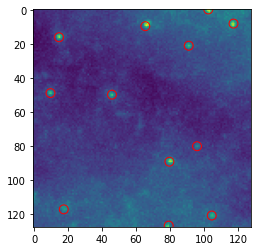

In [31]:
# visualize to check that it loaded correctly
ind=105
plt.imshow(X_keep[ind,...,0])
plt.scatter(y_keep[ind][:,1], y_keep[ind][:,0], edgecolors='r', facecolors='None', s=80)
plt.show()

In [19]:
# Set up required filepaths

modeldir = './models'
logdir = './logs'

# create directories if they do not exist
for d in (modeldir, logdir):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
print('model dir: ', modeldir)
print('log dir: ', logdir)

model dir:  ./models
log dir:  ./logs


In [20]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = 'example_conv_dots_model'

n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

In [21]:
from deepcell_spots.dotnet import dot_net_2D

dots_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=tuple(X_train.shape[1:]),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

In [22]:
dots_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model_10 (Functional)           (None, 128, 128, 128 501504      input_9[0][0]                    
__________________________________________________________________________________________________
offset_regression_head (Functio (None, 128, 128, 2)  2070018     model_10[0][0]                   
__________________________________________________________________________________________________
classification_head (Functional (None, 128, 128, 2)  17282       model_10[0][0]                   
___________________________________________________________________________________________

In [23]:
sigma=3.0
alpha=0.25
gamma=0.5
focal = False

losses = dotnet_losses.DotNetLosses(
    sigma=sigma, alpha=alpha, gamma=gamma, focal=focal)

loss = {
    'offset_regression': losses.regression_loss,
    'classification': losses.classification_loss
}

loss_weights = {"offset_regression": 1.0, "classification": 1.0}
dots_model.compile(loss=loss, loss_weights=loss_weights,
              optimizer=optimizer, metrics=['accuracy'])

In [32]:
rotation_range=0
flip=True
shear=0
zoom_range=0
fill_mode='nearest'
cval=0.
seed=0

datagen = image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=rotation_range,
    shear_range=shear,
    zoom_range=zoom_range,
    horizontal_flip=flip,
    vertical_flip=flip,
    fill_mode=fill_mode,
    cval=cval)

# DataGenerator object for validation data - generates data with no augmentation
datagen_val = image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

if train_dict['X'].ndim == 5:
    train_data = datagen.flow(
        train_dict_filter,
        # skip=skip,
        seed=seed,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch)

    val_data = datagen_val.flow(
        test_dict,
        # skip=skip,
        seed=seed,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch)
else:
    train_data = datagen.flow(
        train_dict_filter,
        # skip=skip,
        seed=seed,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        test_dict,
        # skip=skip,
        seed=seed,
        batch_size=batch_size)

In [ ]:
num_gpus=1
loss_history = dots_model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            modeldir, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=num_gpus >= 2),
        callbacks.TensorBoard(log_dir=os.path.join(logdir, conv_model_name))
    ])

In [36]:
y_pred_test = dots_model.predict(X_test)
print(len(X_test))
print('test image result shape:', y_pred_test[0].shape)

120
test image result shape: (120, 128, 128, 2)


/usr/local/lib/python3.6/dist-packages/deepcell_spots/postprocessing_utils.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(dot_centers)


Text(0.5, 1.0, 'Classification prediction')

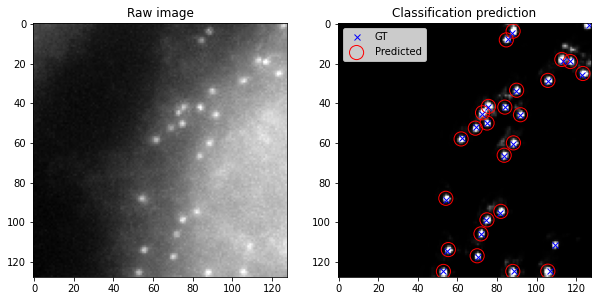

In [42]:
ind = 1
vmax=0.9
# plots results with restrictive decision
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(X_test[ind,...,0],vmax=vmax,cmap='gray')
ax[0].set_title('Raw image')

# mark above threshold pixels (opaque plot over original)
threshold = 0.98
#above_thresh = y_pred_test[1][ind,...,1] > thresh
#plt.imshow(above_thresh, alpha=0.5)
points_list = y_annotations_to_point_list_max(y_pred_test, threshold,min_distance=1)
# plot ground truth centers, and predictions
ax[1].imshow(y_pred_test[1][ind,:,:,1],vmax=vmax,cmap='gray')
ax[1].scatter(points_list[ind][:,1], points_list[ind][:,0],edgecolors='r', facecolors='None',s=200,label='Predicted')
ax[1].plot(y_test[ind][:,1],y_test[ind][:,0],'xb',label='GT')
ax[1].legend()
ax[1].set_title('Classification prediction')